<a href="https://colab.research.google.com/github/Nneka/MachineLearning/blob/main/02_wholetthedogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.5 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *


Cleaning the data or images that we are pulling from the internet.

Below I created an Azure account in order to search for images via Bing.

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '8db3433dff964d1ea775cafa7903d134')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'white dog')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']


In [7]:
dest = 'images/whitedog.jpg'
download_url(ims[0], dest)

Path('images/whitedog.jpg')

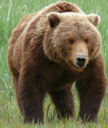

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

Below I and preparing to download all the URLs for each search term and store them in seperate folders.

In [9]:
dog_types = 'whitedog', 'blackdog', 'spotteddog'
path = Path('dog_types')

In [10]:
if not path.exists():
    path.mkdir()
    for o in dog_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} dog')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#424) [Path('dog_types/blackdog/e6df64bc-2d2b-43ad-a2df-2475b75dcea1.jpg'),Path('dog_types/blackdog/5e5977f3-47f4-4351-bb04-9e22683a6b4b.jpg'),Path('dog_types/blackdog/e7176389-4669-4fdf-8651-1f9684d8be61.jpg'),Path('dog_types/blackdog/e671fcb7-48dd-4a05-9f45-089f01956ad9.jpg'),Path('dog_types/blackdog/37dc98d2-584d-49ef-bfdb-e9326e13f4c4.jpg'),Path('dog_types/blackdog/f6fb5a3a-f2c8-45de-9010-b1f357c63a27.jpeg'),Path('dog_types/blackdog/671a62e9-4794-42b4-ade8-881fd7d653e9.jpg'),Path('dog_types/blackdog/22117cc6-d36d-4362-bbb2-bea2e5cbbcc1.jpg'),Path('dog_types/blackdog/9db91bc7-94ff-492c-9365-7277d655e6de.jpg'),Path('dog_types/blackdog/49c16abf-65e0-45b5-a0d9-8bd16ad0a358.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#6) [Path('dog_types/blackdog/722f6fd3-28a3-4379-ba9b-7d81c57da62d.jpg'),Path('dog_types/whitedog/846f968e-215b-4289-8576-edc667ca7cf1.jpg'),Path('dog_types/whitedog/6ad00ff2-094a-48e0-8c9d-13ce172d047e.jpg'),Path('dog_types/spotteddog/d197f3ea-b068-4a23-b493-41d937c30fe3.jpg'),Path('dog_types/spotteddog/71e1087a-5737-4d30-a1dd-4de4946806d2.jpg'),Path('dog_types/spotteddog/cfe75570-1c08-46c8-86ee-763fe8f3e494.jpg')]

In [13]:
failed.map(Path.unlink);

In [14]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
item_tfms=Resize(128)

In [16]:
dls = dogs.dataloaders(path)

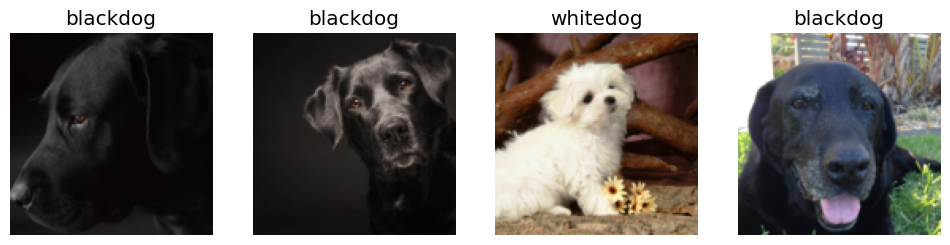

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

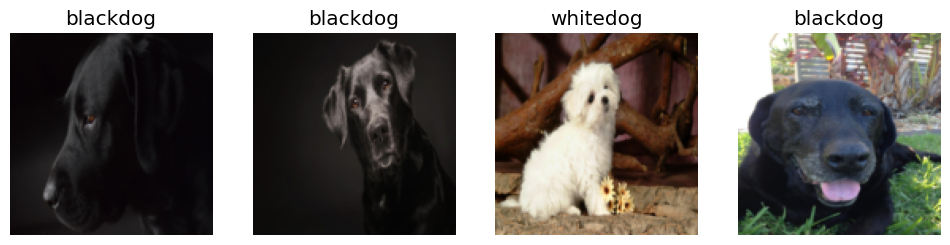

In [18]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


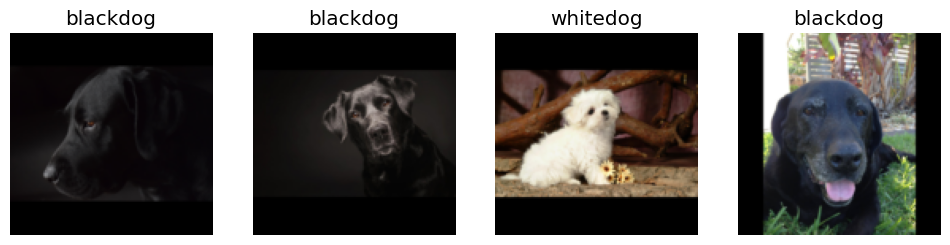

In [19]:
dogs = dogs.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = dogs.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

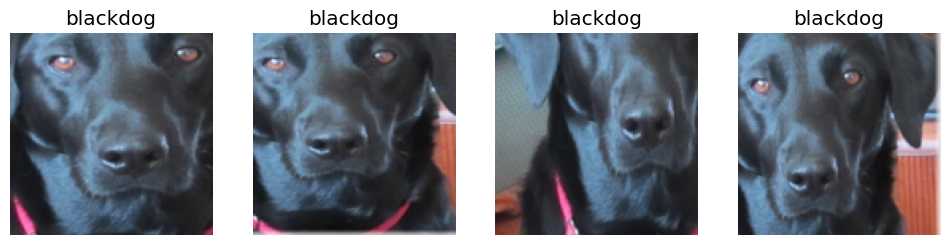

In [20]:
dogs = dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


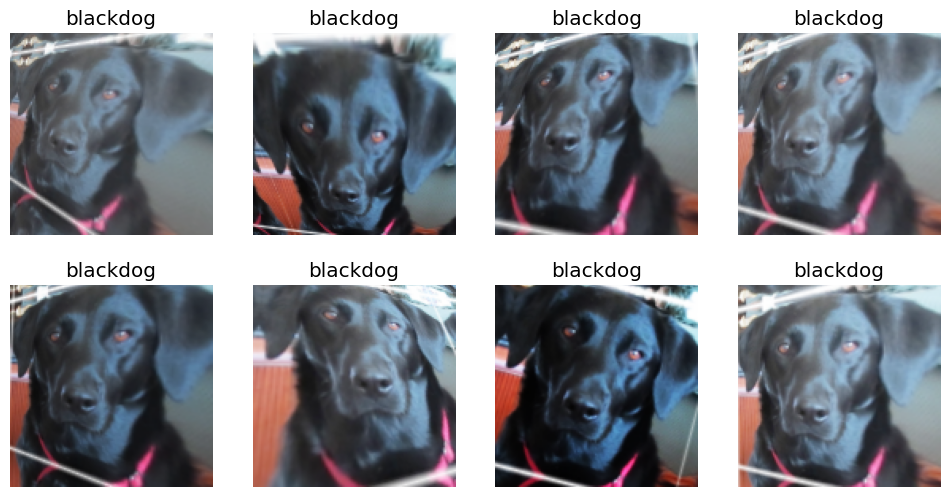

In [21]:
dogs = dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Here is where we begin to train our data.


In [22]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


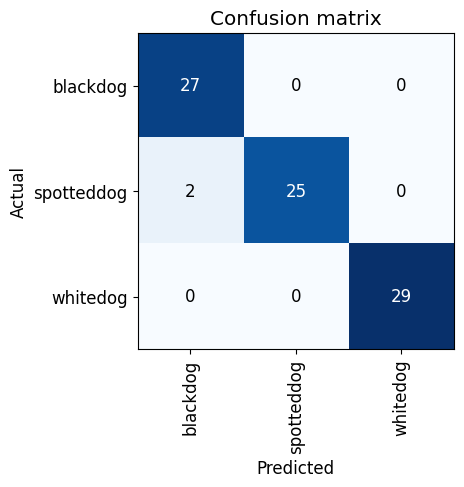

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

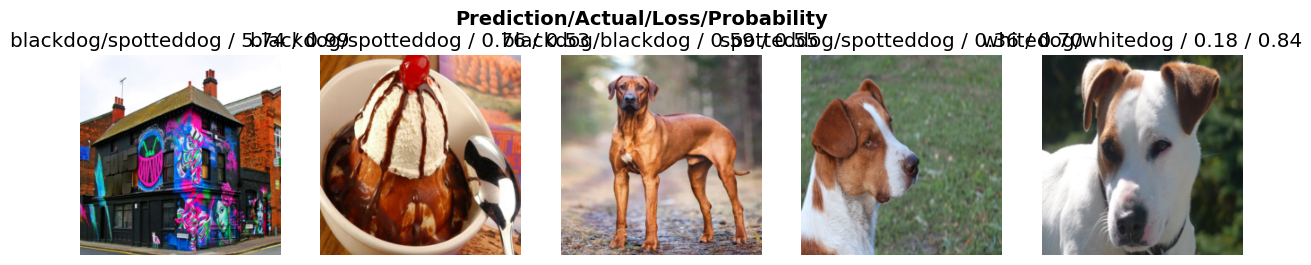

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
